In [11]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sympy import symbols, Matrix, sqrt, simplify, solve, Eq, Abs, expand
import matplotlib as mpl

from matplotlib.gridspec import GridSpec
from scipy.stats import entropy



# 解析解


--- Numpy 数值验证 (Check) ---


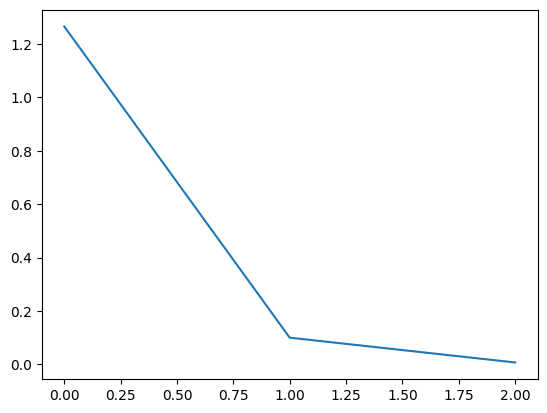

奇异值 (Sigma): [1.26576 0.1     0.00711]


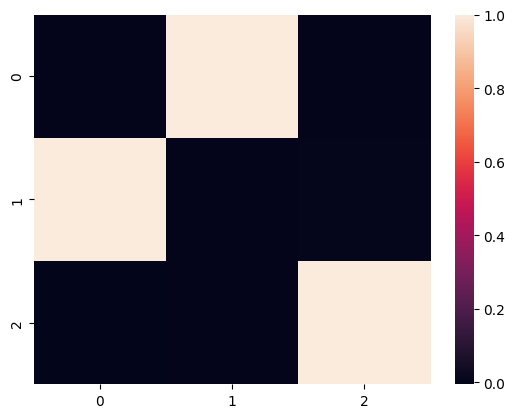

In [2]:
import seaborn as sns

def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [lam, 0, 0],
        [0, mu, lam**2-mu],
        [0, 0, lam**2]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V

    plt.figure()
    plt.plot(S_np)
    plt.show()

    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    sns.heatmap(U_np)

verify_with_numpy(0.1, 0.9)

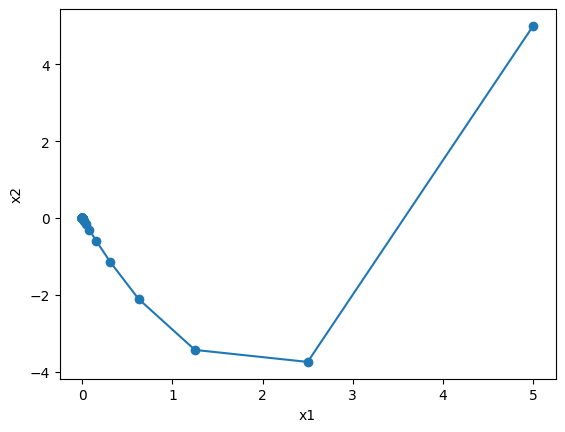

In [3]:
def step(x, y, lam, mu):
    x_next = lam * x
    y_next = mu * y + (lam**2 - mu) * x**2
    return x_next, y_next

def plot_serie(x0, y0, lam=0.01, mu=0.9, steps=100):
    data = np.zeros([steps+1, 2])
    data[0,:] = np.array([x0, y0])
    for s in range(steps):
        x_next, y_next = step(x0, y0, lam, mu)
        data[s+1,:] = np.array([x_next, y_next])
        x0 = x_next
        y0 = y_next
    plt.figure()
    plt.plot(data[:,0], data[:,1], marker = 'o', linestyle = '-')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plot_serie(x0=5, y0=5, lam=0.5, mu=0.5, steps=100)


--- Numpy 数值验证 (Check) ---


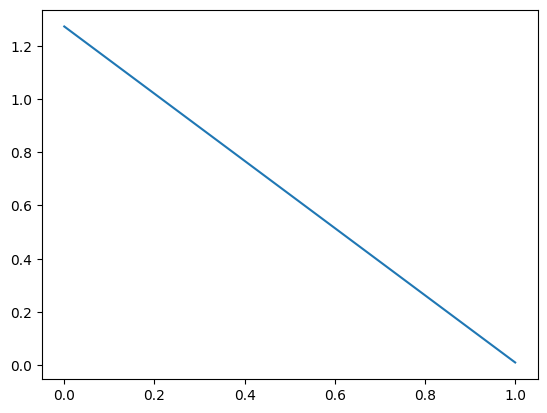

奇异值 (Sigma): [1.27272 0.01   ]

左奇异向量矩阵 U:
[[0. 1.]
 [1. 0.]]

右奇异向量矩阵 V:
[[ 0.       1.       0.     ]
 [ 0.70715  0.       0.70707]
 [-0.70707  0.       0.70715]]


In [4]:
def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [lam, 0, 0],
        [0, mu, lam**2-mu]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V

    plt.figure()
    plt.plot(S_np)
    plt.show()

    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    print("\n左奇异向量矩阵 U:")
    print(np.round(U_np, 5))
    print("\n右奇异向量矩阵 V:")
    print(np.round(V_np, 5))

verify_with_numpy(0.01, 0.9)

In [10]:
# 求解析式子
# 1. 定义符号变量（实数）
lambda_, mu = symbols('lambda mu', real=True)

# 2. 构造矩阵A（沿用你之前的矩阵，可替换为你的实际矩阵）
A = Matrix([
    [lambda_, 0, 0],
    [0, mu, lambda_**2 - mu],
    [0, 0, lambda_**2]
])

# 3. 计算A^T*A并求特征值（奇异值的平方）
A_T_A = A.T * A
eig_vals = A_T_A.eigenvals(multiple=True)  # 按重数返回特征值
eig_vals = [simplify(val) for val in eig_vals]  # 化简特征值

# 4. 奇异值（非负根）
sv = [sqrt(val) for val in eig_vals]
sv = [simplify(v) for v in sv]
print("奇异值解析式：")
for i, s in enumerate(sv, 1):
    print(f"σ_{i} = {s}")

奇异值解析式：
σ_1 = Abs(lambda)
σ_2 = sqrt(lambda**4 - lambda**2*mu + mu**2 + (lambda**2 - mu)*sqrt(lambda**4 + mu**2))
σ_3 = sqrt(lambda**4 - lambda**2*mu + mu**2 - (lambda**2 - mu)*sqrt(lambda**4 + mu**2))


In [12]:
def compute_singular_values(lam, miu):
    """
    计算给定λ和μ时的奇异值
    """
    A = np.array([
        [lam, 0, 0],
        [0, miu, lam**2 - miu],
        [0, 0, lam**2]
    ])
    sv = np.linalg.svd(A, compute_uv=False)  
    sv = np.sort(sv)[::-1]
    return sv[0], sv[1], sv[2]

In [13]:
def compute_singular_value_entropy(sv1, sv2, sv3):
    """
    计算奇异值的归一化熵
    """
    # 归一化奇异值
    sv_sum = sv1 + sv2 + sv3
    if sv_sum == 0:
        return 0
    p1 = sv1 / sv_sum
    p2 = sv2 / sv_sum
    p3 = sv3 / sv_sum
    
    # 计算熵
    prob_dist = np.array([p1, p2, p3])
    # 避免log(0)的情况
    prob_dist = np.clip(prob_dist, 1e-10, 1.0)
    ent = entropy(prob_dist, base=2)  # 以2为底，单位是比特
    
    # 归一化到[0,1]范围（最大熵为log2(3)≈1.585）
    max_ent = np.log2(3)
    normalized_ent = ent / max_ent
    
    return normalized_ent

In [14]:
def generate_data_and_analyze(lam_values=None, log_min=-4, log_max=4, n_points=200):
    """
    使用lam:mu比值作为横轴
    """
    if lam_values is None:
        # 默认使用10个λ值，覆盖小、中、大值
        lam_values = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0]

    print(f"λ值列表: {lam_values}")
    print(f"lam:mu比值范围: [10^{log_min}, 10^{log_max}]")
    print(f"采样点数: {n_points}")

    # 生成 lam:mu 比值（对数均匀分布）
    log_ratios = np.linspace(log_min, log_max, n_points)
    ratios = 10 ** log_ratios

    results = {}
    for lam in lam_values:
        results[lam] = {
            'ratios': ratios,           # lam:mu比值
            'sv1': [],                  # 最大奇异值
            'sv2': [],                  # 中间奇异值
            'sv3': [],                  # 最小奇异值
            'sv_diffs': [],             # 奇异值差异
            'entropy': []               # 奇异值熵
        }

        for ratio in ratios:
            miu = lam / ratio  # lam:mu = ratio:1
            
            sv1, sv2, sv3 = compute_singular_values(lam, miu)
            ent = compute_singular_value_entropy(sv1, sv2, sv3)
            
            results[lam]['sv1'].append(sv1)
            results[lam]['sv2'].append(sv2)
            results[lam]['sv3'].append(sv3)
            results[lam]['sv_diffs'].append([sv1 - sv2, sv2 - sv3, sv3 - 0])
            results[lam]['entropy'].append(ent)

    return results, lam_values, ratios

In [17]:
def plot_combined_analysis(results, lam_values, ratios):
    """
    综合视图：三个子图显示奇异值、奇异值差和熵
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16))
    
    # 统一的色系定义
    sv_colors = ['#E74C3C', '#3498DB', '#2ECC71']  # 红、蓝、绿：σ1, σ2, σ3
    diff_colors = ['#8E44AD', '#F39C12', '#16A085']  # 紫、橙、青：σ1-σ2, σ2-σ3, σ3-0
    entropy_color = '#2C3E50'  # 深蓝色：熵
    
    # 为不同的λ值设置不同的透明度（λ越大，颜色越深）
    n_lam = len(lam_values)
    alphas = np.linspace(0.3, 0.9, n_lam)  # 透明度从0.3到0.9
    
    # 第一个子图：奇异值散点图（横坐标：lam:mu比值）
    for i, lam in enumerate(lam_values):
        alpha = alphas[i]
        sv1 = results[lam]['sv1']
        sv2 = results[lam]['sv2']
        sv3 = results[lam]['sv3']
        
        # 使用散点图，不同奇异值用不同颜色，不同λ用不同透明度
        ax1.scatter(ratios, sv1, color=sv_colors[0], alpha=alpha, 
                   s=20, label=f'σ1 (λ={lam})' if i == 0 else "")
        ax1.scatter(ratios, sv2, color=sv_colors[1], alpha=alpha, 
                   s=20, label=f'σ2 (λ={lam})' if i == 0 else "")
        ax1.scatter(ratios, sv3, color=sv_colors[2], alpha=alpha, 
                   s=20, label=f'σ3 (λ={lam})' if i == 0 else "")
    
    ax1.set_xlabel('lam:mu ratio', fontsize=12)
    ax1.set_ylabel('Singular Values', fontsize=12)
    ax1.set_title('Singular Values vs lam:mu ratio (Scatter Plot)', fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    #ax1.grid(True, alpha=0.3, which='both')
    
    # 为图例创建代理艺术家
    from matplotlib.patches import Patch
    legend_elements1 = [
        Patch(facecolor=sv_colors[0], label='σ1 (max)'),
        Patch(facecolor=sv_colors[1], label='σ2 (mid)'),
        Patch(facecolor=sv_colors[2], label='σ3 (min)')
    ]
    ax1.legend(handles=legend_elements1, loc='upper right')
    
    # 第二个子图：奇异值差异散点图
    diff_names = ['σ1-σ2', 'σ2-σ3', 'σ3-0']
    for i, lam in enumerate(lam_values):
        alpha = alphas[i]
        sv_diffs = np.array(results[lam]['sv_diffs'])
        
        for j in range(3):
            ax2.scatter(ratios, sv_diffs[:, j], color=diff_colors[j], alpha=alpha,
                       s=20, label=f'{diff_names[j]} (λ={lam})' if i == 0 else "")
    
    ax2.set_xlabel('lam:mu ratio', fontsize=12)
    ax2.set_ylabel('Singular Value Differences', fontsize=12)
    ax2.set_title('Singular Value Differences vs lam:mu ratio (Scatter Plot)', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    #ax2.grid(True, alpha=0.3, which='both')
    ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.7)
    
    # 差异图图例
    legend_elements2 = [
        Patch(facecolor=diff_colors[0], label='σ1-σ2'),
        Patch(facecolor=diff_colors[1], label='σ2-σ3'),
        Patch(facecolor=diff_colors[2], label='σ3-0')
    ]
    ax2.legend(handles=legend_elements2, loc='upper right')
    
    # 第三个子图：奇异值熵（线图）
    # 定义颜色映射
    colors = plt.cm.viridis(np.linspace(0, 1, len(lam_values)))

    for i, lam in enumerate(lam_values):
        alpha = alphas[i]
        entropy_vals = results[lam]['entropy']
        # 使用不同颜色，固定透明度
        ax3.semilogx(ratios, entropy_vals, color=colors[i],linewidth=2, label=f'λ={lam}')
        
    ax3.set_xlabel('lam:mu ratio', fontsize=12)
    ax3.set_ylabel('Normalized Entropy', fontsize=12)
    ax3.set_title('Normalized Singular Value Entropy vs lam:mu ratio', fontsize=14, fontweight='bold')
    #ax3.grid(True, alpha=0.3, which='both')
    ax3.set_ylim(0, 1.1)
    
    # 熵图图例（显示所有λ值）
    ax3.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    

λ值列表: [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
lam:mu比值范围: [10^-4, 10^4]
采样点数: 10


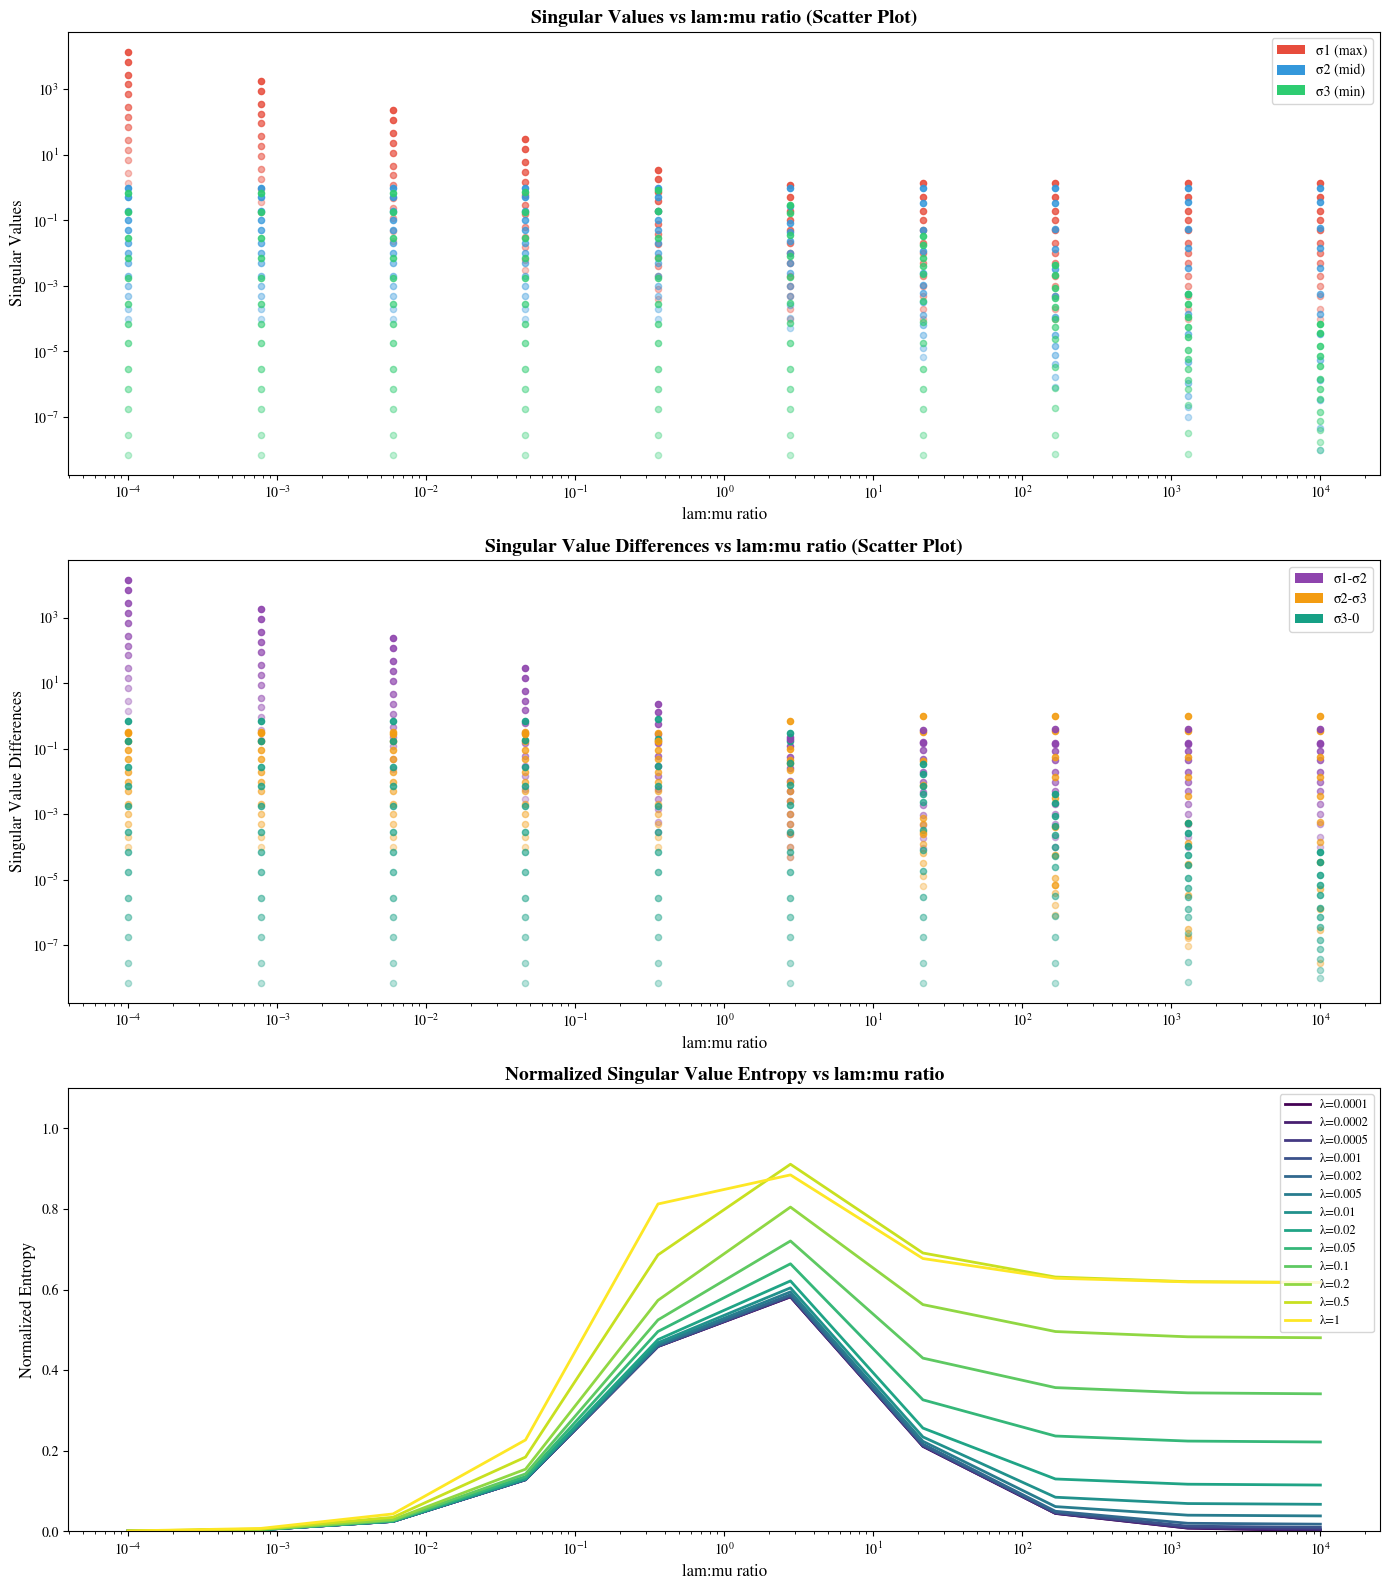

In [18]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
results, lam_values, ratios = generate_data_and_analyze(lam_values=[0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1], 
                                                          log_min=-4, log_max=4, n_points=10)
plot_combined_analysis(results, lam_values, ratios)

# SVD vs EVD

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

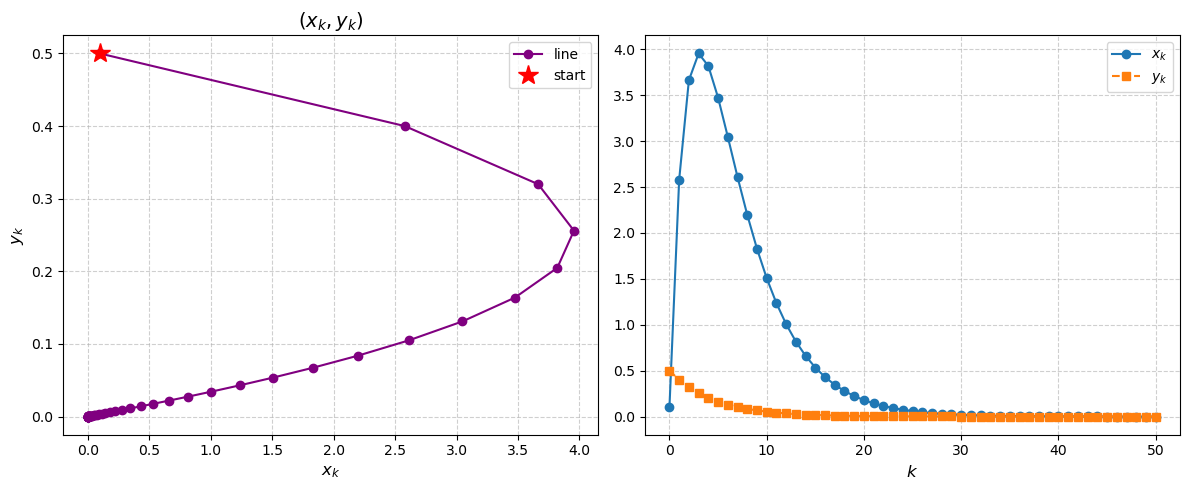

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 定义离散动力学方程
def step_dynamics(x, y):
    """
    根据给定的方程计算下一步状态:
    x_{k+1} = 0.8 * x_k + 10 * y_k^2
    y_{k+1} = 0.8 * y_k
    """
    x_next = 0.8 * x + 10 * (y ** 2)
    y_next = 0.8 * y
    return x_next, y_next

# 2. 设置参数和初始条件
steps = 50          # 模拟的总步数
x0, y0 = 0.1, 0.5   # 初始点 (选择 y0 不为 0 以触发 y^2 项对 x 的驱动)

# 初始化数组来存储轨迹
x_hist = np.zeros(steps + 1)
y_hist = np.zeros(steps + 1)
x_hist[0] = x0
y_hist[0] = y0

# 3. 迭代计算
for k in range(steps):
    x_next, y_next = step_dynamics(x_hist[k], y_hist[k])
    x_hist[k+1] = x_next
    y_hist[k+1] = y_next

# 4. 绘图设置 (使用支持中文的字体，如果没有SimHei可以改为英文)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 创建画布，包含两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- 子图 1: 相图 (Phase Portrait) ---
ax1.plot(x_hist, y_hist, 'o-', color='purple', label='line')
ax1.plot(x0, y0, 'r*', markersize=15, label='start')  # 标记起点
ax1.set_title('$(x_k, y_k)$', fontsize=14)
ax1.set_xlabel('$x_k$', fontsize=12)
ax1.set_ylabel('$y_k$', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# --- 子图 2: 时间序列 (Time Series) ---
time_steps = np.arange(steps + 1)
ax2.plot(time_steps, x_hist, 'o-', label='$x_k$', color='tab:blue')
ax2.plot(time_steps, y_hist, 's--', label='$y_k$', color='tab:orange')
ax2.set_xlabel('$k$', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

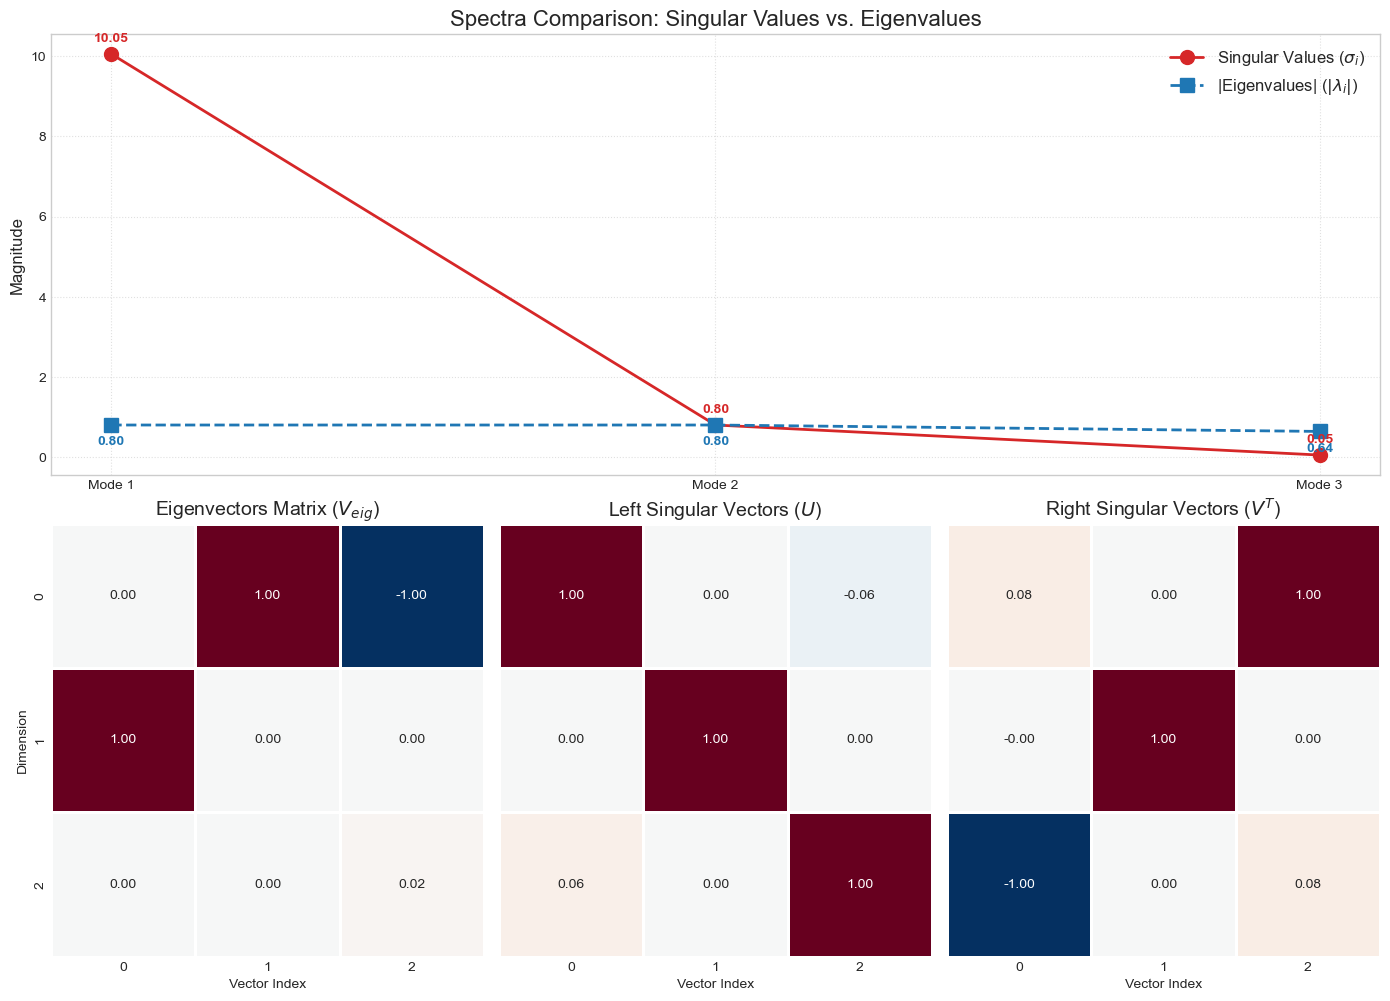

Eigenvalues: [0.8  0.8  0.64]
Singular Values: [10.05221397  0.8         0.05093405]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the Matrix A
A = np.array([
    [0.8, 0.0, 10.0],
    [0.0, 0.8, 0.0],
    [0.0, 0.0, 0.64]
])

# 2. Computations

# Eigenvalue Decomposition
eig_vals, eig_vecs = np.linalg.eig(A)
# Sort eigenvalues by magnitude (descending) for better visualization
idx = np.argsort(np.abs(eig_vals))[::-1]
eig_vals_sorted = eig_vals[idx]
eig_vecs_sorted = eig_vecs[:, idx]

# Singular Value Decomposition (SVD)
# A = U * Sigma * Vt
U, S, Vt = np.linalg.svd(A)

# 3. Visualization

# Set up the figure structure
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(14, 10))

# --- Plot 1: Spectra Comparison (Eigenvalues vs Singular Values) ---
ax1 = fig.add_subplot(2, 1, 1)

# Plot Singular Values
ax1.plot(range(1, 4), S, 'o-', color='#d62728', linewidth=2, markersize=10, label='Singular Values ($\sigma_i$)')

# Plot Eigenvalues (Absolute magnitude)
ax1.plot(range(1, 4), np.abs(eig_vals_sorted), 's--', color='#1f77b4', linewidth=2, markersize=10, label='|Eigenvalues| ($|\lambda_i|$)')

# Annotate values
for i, val in enumerate(S):
    ax1.text(i+1, val + 0.3, f"{val:.2f}", ha='center', color='#d62728', fontweight='bold')
for i, val in enumerate(np.abs(eig_vals_sorted)):
    ax1.text(i+1, val - 0.5, f"{val:.2f}", ha='center', color='#1f77b4', fontweight='bold')

ax1.set_title('Spectra Comparison: Singular Values vs. Eigenvalues', fontsize=16)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['Mode 1', 'Mode 2', 'Mode 3'])
ax1.set_ylabel('Magnitude', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)


# --- Plot 2: Vector Matrices Visualization (Heatmaps) ---
# Create a row of 3 subplots for the matrices
ax2 = fig.add_subplot(2, 3, 4)
ax3 = fig.add_subplot(2, 3, 5)
ax4 = fig.add_subplot(2, 3, 6)

heatmap_args = {
    'annot': True, 
    'fmt': ".2f", 
    'cmap': "RdBu_r", 
    'center': 0, 
    'cbar': False,
    'square': True,
    'linewidths': 1
}

# Eigenvectors
sns.heatmap(eig_vecs_sorted, ax=ax2, **heatmap_args)
ax2.set_title('Eigenvectors Matrix ($V_{eig}$)', fontsize=14)
ax2.set_xlabel('Vector Index')
ax2.set_ylabel('Dimension')

# Left Singular Vectors (U)
sns.heatmap(U, ax=ax3, **heatmap_args)
ax3.set_title('Left Singular Vectors ($U$)', fontsize=14)
ax3.set_xlabel('Vector Index')
ax3.set_yticks([]) # Hide y ticks for cleaner look

# Right Singular Vectors (V^T)
sns.heatmap(Vt, ax=ax4, **heatmap_args)
ax4.set_title('Right Singular Vectors ($V^T$)', fontsize=14)
ax4.set_xlabel('Vector Index')
ax4.set_yticks([]) 

plt.tight_layout()
plt.show()

# Print text results for verification
print("Eigenvalues:", eig_vals)
print("Singular Values:", S)

=== EDMD 得到的 Koopman 矩阵 ===
[[ 0.8  -0.   10.  ]
 [ 0.    0.8  -0.  ]
 [-0.   -0.    0.64]]

注：观察第一行第三列的系数，那就是非线性耦合项
----------------------------------------
最大特征值模长 |lambda_max| = 0.8000  (< 1, 预测稳定)
最大奇异值     sigma_max      = 10.0522  (> 1, 预测增长!)
----------------------------------------


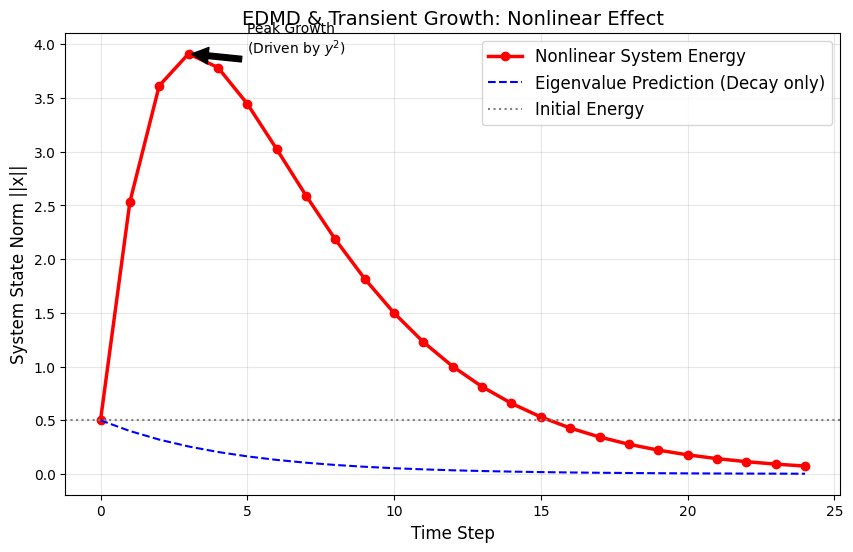

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def nonlinear_transient_growth_edmd():
    # 1. 准备数据：在状态空间随机采样一些点
    n_samples = 100
    X = np.random.uniform(-1, 1, (2, n_samples))
    
    # 2. 定义非线性动力学 (Ground Truth)
    # x_{k+1} = 0.8*x_k + 10 * y_k^2
    # y_{k+1} = 0.8*y_k
    X_next = np.zeros_like(X)
    X_next[0, :] = 0.8 * X[0, :] + 10 * (X[1, :] ** 2)
    X_next[1, :] = 0.8 * X[1, :]
    
    # 3. EDMD 步骤
    # 构造字典 (Observables): [x, y, y^2]
    # 这是一个 invariant subspace，所以结果会非常精确
    def lift(data):
        # data shape: (2, n)
        x = data[0, :]
        y = data[1, :]
        # 返回形状 (3, n) -> [x, y, y^2]
        return np.vstack([x, y, y**2])

    Psi_X = lift(X)      # 当前时刻的观测
    Psi_Y = lift(X_next) # 下一时刻的观测
    
    # 计算 Koopman 算子 K (使得 Psi_Y approx K @ Psi_X)
    # K = Psi_Y @ Psi_X_pinv
    K = Psi_Y @ np.linalg.pinv(Psi_X)
    
    print("=== EDMD 得到的 Koopman 矩阵 ===")
    print(np.round(K, 3))
    print("\n注：观察第一行第三列的系数，那就是非线性耦合项")

    # 4. 矩阵分析 (EVD vs SVD)
    eigvals, _ = np.linalg.eig(K)
    _, s_vals, _ = np.linalg.svd(K)
    
    max_eig = np.max(np.abs(eigvals))
    max_svd = np.max(s_vals)
    
    print("-" * 40)
    print(f"最大特征值模长 |lambda_max| = {max_eig:.4f}  (< 1, 预测稳定)")
    print(f"最大奇异值     sigma_max      = {max_svd:.4f}  (> 1, 预测增长!)")
    print("-" * 40)

    # 5. 轨迹演示
    # 初始状态：x=0, y=0.5 (y^2 = 0.25)
    # 虽然 y 不算极大，但系数 10 会把它放大
    x_curr = np.array([0.0, 0.5]) 
    
    steps = 25
    energy = [] # 用 x^2 + y^2 度量系统能量
    
    for _ in range(steps):
        norm = np.linalg.norm(x_curr)
        energy.append(norm)
        
        # 真实非线性演化
        x_new = 0.8 * x_curr[0] + 10 * (x_curr[1]**2)
        y_new = 0.8 * x_curr[1]
        x_curr = np.array([x_new, y_new])
        
    # 6. 绘图
    plt.figure(figsize=(10, 6))
    
    # 真实轨迹
    plt.plot(range(steps), energy, 'r-o', linewidth=2.5, label='Nonlinear System Energy')
    
    # 特征值预测的衰减边界 (假设只有衰减)
    # 以初始能量为起点，按 0.8^k 衰减
    decay = [energy[0] * (0.8**k) for k in range(steps)]
    plt.plot(range(steps), decay, 'b--', label='Eigenvalue Prediction (Decay only)')
    
    plt.axhline(y=energy[0], color='gray', linestyle=':', label='Initial Energy')
    plt.title('EDMD & Transient Growth: Nonlinear Effect', fontsize=14)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('System State Norm ||x||', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 标注峰值
    peak_idx = np.argmax(energy)
    plt.annotate(f'Peak Growth\n(Driven by $y^2$)', 
                 xy=(peak_idx, energy[peak_idx]), 
                 xytext=(peak_idx+2, energy[peak_idx]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

if __name__ == "__main__":
    nonlinear_transient_growth_edmd()


In [7]:
n_samples = 100
X = np.random.uniform(-1, 1, (2, n_samples))

# 2. 定义非线性动力学 (Ground Truth)
# x_{k+1} = 0.8*x_k + 10 * y_k^2
# y_{k+1} = 0.8*y_k
X_next = np.zeros_like(X)
X_next[0, :] = 0.8 * X[0, :] + 10 * (X[1, :] ** 2)
X_next[1, :] = 0.8 * X[1, :]

# 3. EDMD 步骤
# 构造字典 (Observables): [x, y, y^2]
# 这是一个 invariant subspace，所以结果会非常精确
def lift(data):
    # data shape: (2, n)
    x = data[0, :]
    y = data[1, :]
    # 返回形状 (3, n) -> [x, y, y^2]
    return np.vstack([x, y, y**2])

Psi_X = lift(X)      # 当前时刻的观测
Psi_Y = lift(X_next) # 下一时刻的观测

# 计算 Koopman 算子 K (使得 Psi_Y approx K @ Psi_X)
# K = Psi_Y @ Psi_X_pinv
K = Psi_Y @ np.linalg.pinv(Psi_X)

In [8]:
K

array([[ 8.00000000e-01,  6.10622664e-16,  1.00000000e+01],
       [-8.32667268e-17,  8.00000000e-01, -5.55111512e-17],
       [-6.24500451e-17,  4.85722573e-17,  6.40000000e-01]])

In [6]:
eigvals, eig_vect = np.linalg.eig(K)
U, s_vals, V = np.linalg.svd(K)

eigvals, s_vals

(array([0.64, 0.8 , 0.8 ]), array([10.05221397,  0.8       ,  0.05093405]))

<Axes: >

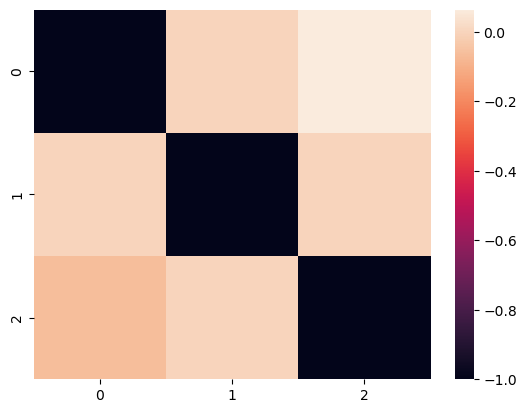

In [5]:
import seaborn as sns

sns.heatmap(U)

<Axes: >

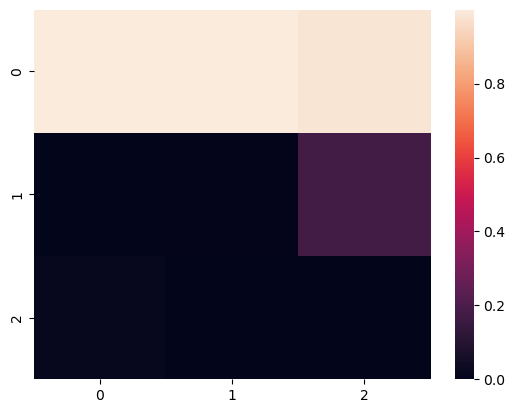

In [7]:
sns.heatmap(np.abs(eig_vect))